Dataset Shape: (3000, 2)

Class Distribution:
Liked
0    0.5
1    0.5
Name: proportion, dtype: float64

--- Pooling Strategy: mean ---


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]


Model Evaluation:
Training Accuracy: 0.4990476190476191
Validation Accuracy: 0.5
Test Accuracy: 0.5

Classification Report (Train Set):
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      1050
           1       0.00      0.00      0.00      1050

    accuracy                           0.50      2100
   macro avg       0.25      0.50      0.33      2100
weighted avg       0.25      0.50      0.33      2100


Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       150
           1       0.00      0.00      0.00       150

    accuracy                           0.50       300
   macro avg       0.25      0.50      0.33       300
weighted avg       0.25      0.50      0.33       300


Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       300
           1       0.00 

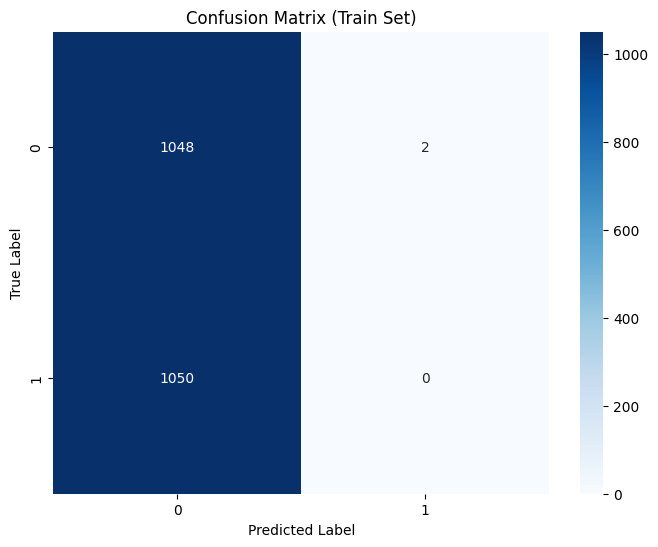

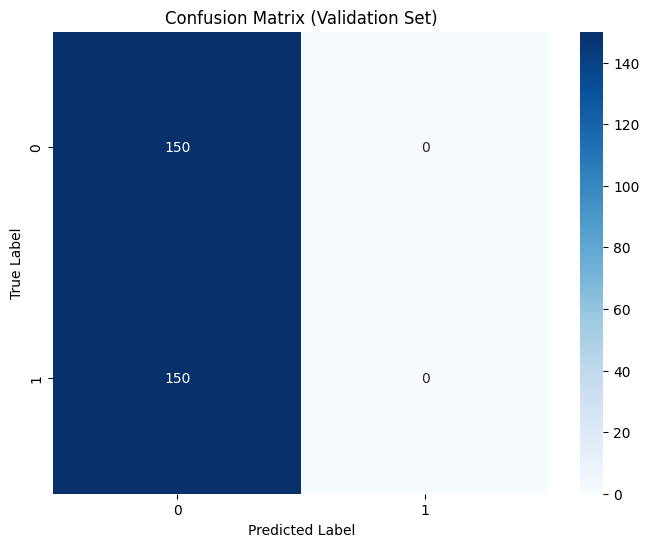

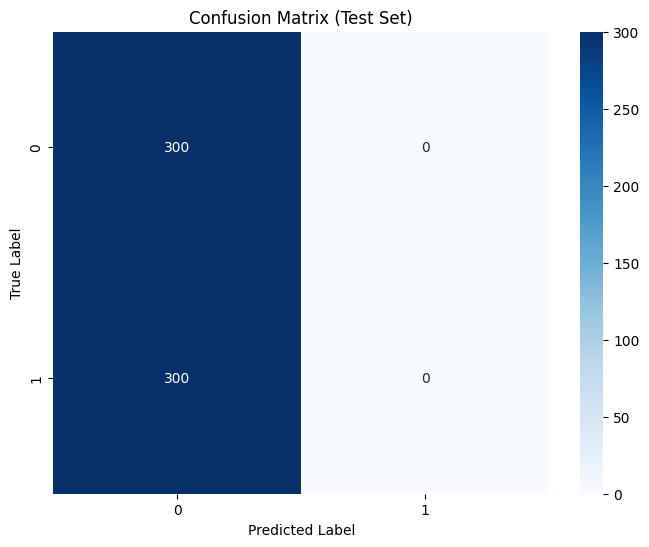


Example Predictions:

Review: An excellent wine with great balance and complexity. Rich flavors of dark fruit and oak.
Prediction: Not Liked
Probability: Positive=0.476, Negative=0.524

Review: Simple and straightforward. Somewhat bland with little character.
Prediction: Not Liked
Probability: Positive=0.484, Negative=0.516

Review: Amazing depth with perfect tannins. A masterpiece of winemaking.
Prediction: Not Liked
Probability: Positive=0.486, Negative=0.514


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertModel, DistilBertTokenizerFast
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import namedtuple
import warnings
warnings.filterwarnings('ignore')

def load_and_prepare_data(file_path):

    df = pd.read_csv(file_path)


    df = df[['description', 'points']]

    df['sentiment'] = df['points'].apply(lambda x: 1 if x >= 90 else 0)

    df = df.drop('points', axis=1)

    df.columns = ['Review', 'Liked']

    return df
class WineReviewDataset(Dataset):
    def __init__(self, reviews, labels, tokenizer, max_len=128):

        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = str(self.reviews[idx]).lower()

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }



class DistilBERTWithPooling(nn.Module):
    def __init__(self, model_name='distilbert-base-uncased', pooling_type='mean'):
        super().__init__()


        self.bert = DistilBertModel.from_pretrained(model_name)

        self.pooling_type = pooling_type

        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(self.bert.config.dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 2)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        hidden_states = outputs.last_hidden_state

        if self.pooling_type == 'mean':
            masked_hidden_states = hidden_states * attention_mask.unsqueeze(-1).float()
            pooled_output = masked_hidden_states.sum(1) / attention_mask.sum(1, keepdim=True).float()

        elif self.pooling_type == 'max':
            masked_hidden_states = hidden_states.clone()
            extended_attention_mask = attention_mask.unsqueeze(-1).expand(masked_hidden_states.size())
            pooled_output, _ = masked_hidden_states.max(1)

        else: #for cls
            pooled_output = hidden_states[:, 0, :]

        logits = self.classifier(pooled_output)

        ModelOutput = namedtuple('ModelOutput', ['logits'])
        return ModelOutput(logits=logits)



def create_baseline_model(df, val_size=0.1, test_size=0.2, random_state=42,
                           model_name='distilbert-base-uncased',
                           pooling_type='mean',
                           max_len=128,
                           batch_size=16):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    X = df['Review']
    y = df['Liked']

    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_size/(1-test_size),
        random_state=random_state, stratify=y_train_val
    )

    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    X_val = X_val.reset_index(drop=True)
    y_val = y_val.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

    train_dataset = WineReviewDataset(X_train, y_train, tokenizer, max_len)
    val_dataset = WineReviewDataset(X_val, y_val, tokenizer, max_len)
    test_dataset = WineReviewDataset(X_test, y_test, tokenizer, max_len)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    model = DistilBERTWithPooling(
        model_name=model_name,
        pooling_type=pooling_type
    ).to(device)

    return model, tokenizer, train_loader, val_loader, test_loader, y_train, y_val, y_test, device


def evaluate_model(model, train_loader, val_loader, test_loader,
                   y_train, y_val, y_test, device):


    model.eval()

    def get_predictions(loader):
        predictions, true_labels = [], []
        with torch.no_grad():
            for batch in loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids, attention_mask=attention_mask)
                preds = torch.argmax(outputs.logits, dim=1)

                predictions.extend(preds.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())

        return predictions, true_labels

    train_pred, train_true = get_predictions(train_loader)
    val_pred, val_true = get_predictions(val_loader)
    test_pred, test_true = get_predictions(test_loader)

    print("Training Accuracy:", accuracy_score(train_true, train_pred))
    print("Validation Accuracy:", accuracy_score(val_true, val_pred))
    print("Test Accuracy:", accuracy_score(test_true, test_pred))

    print("\nClassification Report (Train Set):")
    print(classification_report(train_true, train_pred))

    print("\nClassification Report (Validation Set):")
    print(classification_report(val_true, val_pred))

    print("\nClassification Report (Test Set):")
    print(classification_report(test_true, test_pred))

    cm = confusion_matrix(train_true, train_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix (Train Set)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    cm = confusion_matrix(val_true, val_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix (Validation Set)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    cm = confusion_matrix(test_true, test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix (Test Set)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def predict_sentiment(model, tokenizer, review_text, device, max_len=128):
     : Prediction and probabilities
    model.eval()

    processed_text = str(review_text).lower()

    encoding = tokenizer.encode_plus(
        processed_text,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        probabilities = torch.softmax(outputs.logits, dim=1)
        prediction = torch.argmax(probabilities, dim=1)
        confidence = probabilities[0][prediction].item()

    return prediction.cpu().item(), probabilities[0].cpu().numpy()

def main():
    file_path = "wine_small_balanced.csv"
    df = load_and_prepare_data(file_path)

    print("Dataset Shape:", df.shape)
    print("\nClass Distribution:")
    print(df['Liked'].value_counts(normalize=True))

    pooling_strategies = ['mean']#, 'max', 'cls']

    for pooling in pooling_strategies:
        print(f"\n--- Pooling Strategy: {pooling} ---")

        model, tokenizer, train_loader, val_loader, test_loader, y_train, y_val, y_test, device = create_baseline_model(
            df,
            pooling_type=pooling
        )

        print("\nModel Evaluation:")
        evaluate_model(model, train_loader, val_loader, test_loader, y_train, y_val, y_test, device)

        print("\nExample Predictions:")
        example_reviews = [
            "An excellent wine with great balance and complexity. Rich flavors of dark fruit and oak.",
            "Simple and straightforward. Somewhat bland with little character.",
            "Amazing depth with perfect tannins. A masterpiece of winemaking."
        ]

        for review in example_reviews:
            prediction, probability = predict_sentiment(model, tokenizer, review, device)
            print(f"\nReview: {review}")
            print(f"Prediction: {'Liked' if prediction == 1 else 'Not Liked'}")
            print(f"Probability: Positive={probability[1]:.3f}, Negative={probability[0]:.3f}")

if __name__ == "__main__":
    main()